In [46]:
from fermi_model import *
%matplotlib inline

In [3]:
def scatter(xs, ys):
    plt.scatter(xs, ys, s=2)
    plt.yscale("log")
    plt.show()

In [4]:
states3 = csv_to_states()

In [5]:
def sum_along_axis(matrix: NDArray[np.float64], axis: int = 0):
    return np.apply_along_axis(np.sum, axis, matrix)

In [6]:
def power(matrix):
    x = np.zeros(matrix.shape[0])
    x[0] = 1
    eigen_past = 0
    while True:
        y = np.dot(matrix, x)
        eigen = np.dot(y, y) / np.dot(y, x)
        if np.abs(eigen_past - eigen) < 1e-15:
            return eigen, x
        x = y / np.linalg.norm(y)
        eigen_past = eigen

def power2(matrix):
    x = np.zeros(matrix.shape[0])
    x[1] = 1
    eigen_past = 0
    cnt = 0
    while True:
        y = np.dot(matrix, x)
        eigen = np.dot(y, y) / np.dot(y, x)
        if np.abs(eigen_past - eigen) < 1e-15 or cnt > 100000:
            return eigen, x
        x = y / np.linalg.norm(y)
        eigen_past = eigen
        cnt += 1

def power2_many_loops(matrix):
    x = np.zeros(matrix.shape[0])
    x[1] = 1
    eigen_past = 0
    cnt = 0
    while True:
        y = np.dot(matrix, x)
        eigen = np.dot(y, y) / np.dot(y, x)
        if np.abs(eigen_past - eigen) < 1e-15 or cnt > 500000:
            return eigen, x
        x = y / np.linalg.norm(y)
        eigen_past = eigen
        cnt += 1



In [14]:
fermi = Fermi(states3, equ=False, Te=0.5, ne=0.0001)
states = fermi.states

if np.all(fermi.excitation == 0):
    fermi._make_matrices()
C_ = np.diag(sum_along_axis(fermi.excitation, 1))
F_ = np.diag(sum_along_axis(fermi.deexcitation, 0))
C = fermi.excitation
F = fermi.deexcitation
coeff = C_ - F - C.T + F_
if not fermi.equ:
    A_ = np.diag(sum_along_axis(fermi.emission, 0))
    A = fermi.emission
    coeff += A_ - A

scaled_coeff = np.zeros_like(coeff)
score_0 = states[0].score
for i, state in enumerate(states):
    if i == 0:
        # 単純にスケーリング
        # scaled_coeff[:, 0] = coeff[:, 0] * (1 - sum([fermi.ne * np.exp(-(s.score - score_0) / fermi.Te) / (s.score - score_0) ** 3 for s in states[1:]]))
        # 逆にスケーリング
        scaled_coeff[:, 0] = coeff[:, 0] / (1 - sum([fermi.ne * np.exp(-(s.score - score_0) / fermi.Te) / (s.score - score_0) ** 3 for s in states[1:]]))
    else:
        # scaled_coeff[:, i] = coeff[:, i] * fermi.ne * np.exp(-(state.score - score_0) / fermi.Te) / (state.score - score_0) ** 3
        scaled_coeff[:, i] = coeff[:, i] / (fermi.ne * np.exp(-(state.score - score_0) / fermi.Te) / (state.score - score_0) ** 3)


normalized = -coeff / np.max(np.abs(np.diag(coeff))) + np.eye(C.shape[0])
scaled_normalized = -scaled_coeff / np.max(np.abs(np.diag(scaled_coeff))) + np.eye(scaled_coeff.shape[0])
non_negative = -coeff + np.max(np.abs(np.diag(coeff))) * np.eye(C.shape[0])
scaled_non_negative = -scaled_coeff + np.max(np.abs(np.diag(coeff))) * np.eye(C.shape[0])

In [8]:
np.min(np.abs(normalized)[np.abs(normalized) > 0])

9.633455924313991e-27

In [165]:
print(f"^n_0 = {1 - sum([fermi.ne * np.exp(-(s.score - score_0) / fermi.Te) / (s.score - score_0) ** 3 for s in states[1:]])}")

^n_0 = 0.9999859787386728


In [166]:
print(np.max(np.abs(np.diag(scaled_coeff))) == scaled_coeff[0, 0] )
print("スケーリングしたcoeffの最大要素は[0,0]の位置にあるまま")

True
スケーリングしたcoeffの最大要素は[0,0]の位置にあるまま


## 問題点
* `scaled_coeff` の対角要素の最大値が[0,0]要素なので、`-scaled_coeff / np.max(np.abs(np.diag(scaled_coeff))) + np.eye(..)` の計算で、[0,0]要素が0になってしまう
* 結果として `y = np.dot(matrix, x)` で `y[0] == 0` となり、`np.dot(y, x) == 0` となる

## 対処法
* `x[0] = 1`という初期化箇所を変更
  * **<span style="color: #FF6600;">これでやってみる</span>**
  * 単純だが、x[1] = 1という初期化方法に変更
* `scaled_coeff` の計算の際に[:, 0] の列には定数倍の処理を施さなかったが、$n_e = 0.0001$ 等の小さい値をとったときの基底状態におけるDepopulation, Population fluxを近似的に別で考える
  * $n_0 \approx 1 - \sum_{i\ne0} n_e\exp{[-(E_i-E_0)/T_e]}(E_i-E_0)^{-3} $ と近似する
  * $X_{i0}$ には、$1 - \sum_{i\ne0} n_e\exp{[-(E_i-E_0)/T_e]}(E_i-E_0)^{-3}$をかけるようにする
    * この方法では依然として`scaled_coeff[0, 0]`が`scaled_coeff`の対角要素の中で最大値をとるのでダメ。
    * そもそも $n_i$ の粗い値を出すという意味では、どのように近似をするかは大切だが、計算誤差をなくすという意味でどのような値で定数倍するかはあまり重要ではない(このようにスケーリングすることによって、べき乗法で計算した結果の各要素が1に近い値として出力されるが。)

    

<br><br><br><br>

In [11]:
coeff_abs = np.abs(coeff)
scaled_coeff_abs = np.abs(scaled_coeff)
print("スケール前の0より大きい最小値: ", np.min(coeff_abs[coeff_abs > 0]))
print("スケール後の0より大きい最小値; ", np.min(scaled_coeff_abs[scaled_coeff_abs > 0]))

スケール前の0より大きい最小値:  4.248354255291589e-22
スケール後の0より大きい最小値;  6.193839124204096e-30


In [167]:
max_val = np.max(np.abs(np.diag(scaled_coeff)))
diag_coeff = np.abs(np.diag(scaled_coeff))
second_val = np.max(diag_coeff[diag_coeff < max_val])
print(f"スケーリングしたcoeffの最大値: {max_val}, スケーリングしたcoeffの二番目に大きい値: {second_val}")

スケーリングしたcoeffの最大値: 1.8056419111382875e-05, スケーリングしたcoeffの二番目に大きい値: 1.3535305848742098e-05


In [168]:
print("スケールしたcoeffの対角要素の最大値: ", np.max(np.abs(np.diag(scaled_coeff))))
print("スケールしたcoeffの対角要素の最小値: ", np.min(np.abs(np.diag(scaled_coeff))))
print("coeffの対角要素の最大値: ", np.max(np.abs(np.diag(coeff))))
print("coeffの対角要素の最小値: ", np.min(np.abs(np.diag(coeff))))

スケールしたcoeffの対角要素の最大値:  1.8056419111382875e-05
スケールしたcoeffの対角要素の最小値:  1.9786720564906212e-22
coeffの対角要素の最大値:  44100.002
coeffの対角要素の最小値:  1.8056672288703736e-05


In [13]:
print(np.min(normalized[normalized >0]))
print(np.min(scaled_normalized[scaled_normalized > 0]))
print("スケーリングした方が、normalizedの0の次に小さい値のオーダーが大きくなっている")
print(np.min(non_negative[non_negative >0]))
print(np.min(scaled_non_negative[scaled_non_negative > 0]))
print("スケーリングした方が、normalizedの0の次に小さい値のオーダーが大きくなっている")

9.633455924313991e-27
3.430269914536633e-25
スケーリングした方が、normalizedの0の次に小さい値のオーダーが大きくなっている
4.248354255291589e-22
6.193839124204096e-30
スケーリングした方が、normalizedの0の次に小さい値のオーダーが大きくなっている


## べき乗法で、x[1] = 1と初期化する

In [143]:
scaled_eigen, scaled_x = power2(scaled_normalized)
x = np.zeros_like(scaled_x)
for i, state in enumerate(states):
    if i == 0:
        x[0] = scaled_x[0] * (1 - sum([fermi.ne * np.exp(-(s.score - score_0) / fermi.Te) / (s.score - score_0) ** 3 for s in states[1:]]))
    else:
        x[i] = scaled_x[i] * (fermi.ne * np.exp(-(state.score - score_0) / fermi.Te) / (state.score - score_0) ** 3)

x = x / np.sum(x)

In [122]:
scores = [state.score for state in states]

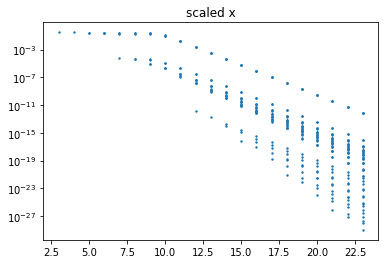

In [123]:
plt.scatter(scores, scaled_x, s=2)
plt.title("scaled x")
plt.yscale("log")
plt.show()

* 本当なら、べき乗法によって求めた出力`scaled_x`はすべての要素が1に近い値をとっておいてほしいところだが、そうはいっていない。つまり近似がそんなにうまいこといっていない。
* 理論上では、スケールをもとに戻した後ならスケーリングなしで計算したときと同じ結果になるはずやけどなぜかなってない。。。
  * これはスケーリングしたやつのほうが正しいのか？
  * でもスケーリングなしの方法で誤差が出てたなら、`np.linalg.eig()`使ったときのように、うねうねした曲線を描く気がするから、スケーリングなしが誤差めっちゃあったとは考えにくい。。。
  * **<span style="color: red">`power2`のループ回数が単純に少ないだけな気もする。</span>**
    * ループ回数を5倍多くしたら、ほーんのちょこっとだけスケールなしのものに近づいた。
    * やっぱり計算式が間違ってるとしか思えない。。。


In [146]:
eigen_origin, x_origin = power(normalized)
x_origin = x_origin / np.sum(x_origin)

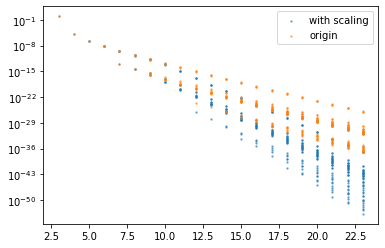

In [130]:
plt.scatter(scores, x, s=2, label="with scaling", alpha=0.5)
plt.scatter(scores, x_origin, s=2, label="origin", alpha=0.5)
plt.legend()
plt.yscale("log")
plt.show()

In [149]:
scaled_eigen_many_loops, scaled_x_many_loops = power2_many_loops(scaled_normalized)
x_many_loops = np.zeros_like(scaled_x_many_loops)
for i, state in enumerate(states):
    if i == 0:
        x_many_loops[0] = scaled_x_many_loops[0] * (1 - sum([fermi.ne * np.exp(-(s.score - score_0) / fermi.Te) / (s.score - score_0) ** 3 for s in states[1:]]))
    else:
        x_many_loops[i] = scaled_x_many_loops[i] * (fermi.ne * np.exp(-(state.score - score_0) / fermi.Te) / (state.score - score_0) ** 3)

x_many_loops = x_many_loops / np.sum(x_many_loops)

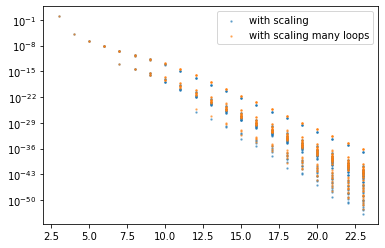

In [139]:
plt.scatter(scores, x, s=2, label="with scaling", alpha=0.5)
plt.scatter(scores, x_many_loops, s=2, label="with scaling many loops", alpha=0.5)
# plt.scatter(scores, x_origin, s=2, label="origin", alpha=0.5)
plt.legend()
plt.yscale("log")
plt.show()

## 直感とは逆にスケーリングし、正規化は行わない

In [27]:
eigen, x = power(scaled_non_negative)
for i, state in enumerate(states):
    if i == 0:
        x[0] = x[0] / (1 - sum([fermi.ne * np.exp(-(s.score - score_0) / fermi.Te) / (s.score - score_0) ** 3 for s in states[1:]]))
    else:
        x[i] = x[i] / (fermi.ne * np.exp(-(state.score - score_0) / fermi.Te) / (state.score - score_0) ** 3)
x = x / np.sum(x)

In [28]:
scores = [state.score for state in states]

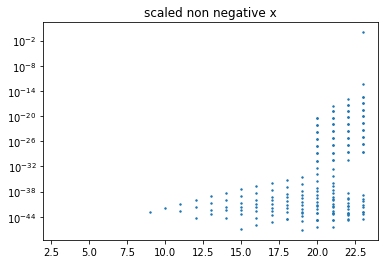

In [30]:
plt.scatter(scores, x, s=2)
plt.title("scaled non negative x")
plt.yscale("log")
plt.show()

* 本当なら、べき乗法によって求めた出力`scaled_x`はすべての要素が1に近い値をとっておいてほしいところだが、そうはいっていない。つまり近似がそんなにうまいこといっていない。
* 理論上では、スケールをもとに戻した後ならスケーリングなしで計算したときと同じ結果になるはずやけどなぜかなってない。。。
  * これはスケーリングしたやつのほうが正しいのか？
  * でもスケーリングなしの方法で誤差が出てたなら、`np.linalg.eig()`使ったときのように、うねうねした曲線を描く気がするから、スケーリングなしが誤差めっちゃあったとは考えにくい。。。
  * **<span style="color: red">`power2`のループ回数が単純に少ないだけな気もする。</span>**
    * ループ回数を5倍多くしたら、ほーんのちょこっとだけスケールなしのものに近づいた。
    * やっぱり計算式が間違ってるとしか思えない。。。


In [ ]:
eigen_origin, x_origin = power(normalized)
x_origin = x_origin / np.sum(x_origin)

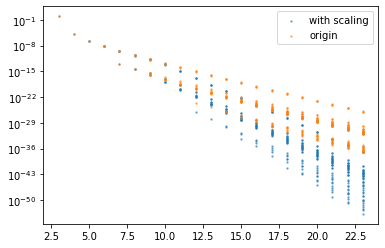

In [ ]:
plt.scatter(scores, x, s=2, label="with scaling", alpha=0.5)
plt.scatter(scores, x_origin, s=2, label="origin", alpha=0.5)
plt.legend()
plt.yscale("log")
plt.show()

In [ ]:
scaled_eigen_many_loops, scaled_x_many_loops = power2_many_loops(scaled_normalized)
x_many_loops = np.zeros_like(scaled_x_many_loops)
for i, state in enumerate(states):
    if i == 0:
        x_many_loops[0] = scaled_x_many_loops[0] * (1 - sum([fermi.ne * np.exp(-(s.score - score_0) / fermi.Te) / (s.score - score_0) ** 3 for s in states[1:]]))
    else:
        x_many_loops[i] = scaled_x_many_loops[i] * (fermi.ne * np.exp(-(state.score - score_0) / fermi.Te) / (state.score - score_0) ** 3)

x_many_loops = x_many_loops / np.sum(x_many_loops)

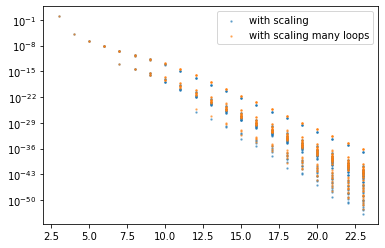

In [ ]:
plt.scatter(scores, x, s=2, label="with scaling", alpha=0.5)
plt.scatter(scores, x_many_loops, s=2, label="with scaling many loops", alpha=0.5)
# plt.scatter(scores, x_origin, s=2, label="origin", alpha=0.5)
plt.legend()
plt.yscale("log")
plt.show()

In [151]:
eigen = np.max(np.linalg.eigvals(scaled_normalized))
print(scaled_eigen, scaled_eigen_many_loops, eigen_origin, eigen)

0.9999996093930303 0.999999934883803 0.9999999999462342 (1.000000000000006+0j)


In [ ]:
0.9999996093930303 0.999999934883803 0.9999999999462342 (1.000000000000006+0j)

## 粗い値を計算してみる
* 意外といい感じで近似できている。
* $n_e$の値を変えたときに、誤差がどうなるのかも見てみたい

In [31]:
ne = 0.0001
Te = 0.5
E_0 = 3
fermi = Fermi(states3, equ=False, Te=Te, ne=ne)
states = fermi.states

ns = []
for i, state in enumerate(states):
    if i == 0:
        ns.append(1 - sum([fermi.ne * np.exp(-(s.score - score_0) / fermi.Te) / (s.score - score_0) ** 3 for s in states[1:]]))
    else:
        ns.append(fermi.ne * np.exp(-(state.score - score_0) / fermi.Te) / (state.score - score_0) ** 3)

In [32]:
scores, distribution = fermi.calc_distribution(use_power=True)

In [33]:
dct = {}
for rate, state in zip(ns, states):
    if dct.get(state.score):
        dct[state.score] += rate
    else:
        dct[state.score] = rate
approx_distribution = np.fromiter(dct.values(), dtype=float)

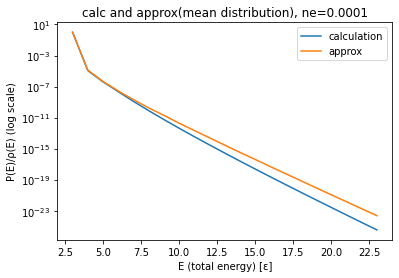

In [36]:
plt.plot(scores, distribution, label="calculation")
plt.plot(scores, approx_distribution, label="approx")
plt.title(f"calc and approx(mean distribution), ne={ne}")
plt.legend()
plt.xlabel("E (total energy) [ε]")
plt.ylabel("P(E)/ρ(E) (log scale)")
plt.yscale("log")
plt.show()

In [44]:
def plots_mean_dist_for_approx(
    ne_lst: list[float],
    Te: float = 0.5,
) -> None:
    states3 = csv_to_states()
    for ne in tqdm(ne_lst):
        fermi = Fermi(states3, equ=False, Te=Te, ne=ne)
        scores, population = fermi.calc_mean_distribution()
        plt.plot(scores, population, label=f"ne = {ne}", marker=".", linewidth=0.8, ms=3)
        ns = []
        score_0 = scores[0]
        for i, state in enumerate(fermi.states):
            if i == 0:
                ns.append(1 - sum([fermi.ne * np.exp(-(s.score - score_0) / fermi.Te) / (s.score - score_0) ** 3 for s in fermi.states[1:]]))
            else:
                ns.append(fermi.ne * np.exp(-(state.score - score_0) / fermi.Te) / (state.score - score_0) ** 3)
        dct = {}
        for rate, state in zip(ns, fermi.states):
            if dct.get(state.score):
                dct[state.score] += rate
            else:
                dct[state.score] = rate
        approx_distribution = np.fromiter(dct.values(), dtype=float)
        plt.plot(scores, approx_distribution, label=f"ne = {ne} (approx)", marker=".", linewidth=0.8, ms=3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
    plt.title(f"mean distribution with approx(T_e = {Te})")
    plt.yscale("log")
    plt.xlabel("E (total energy) [ε]")
    plt.ylabel("P(E)/ρ(E) (log scale)")
    plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

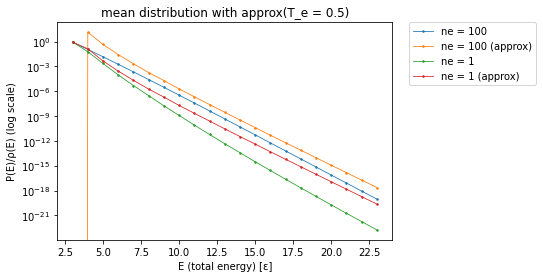

In [42]:
plots_mean_dist_for_approx([100, 1])

  0%|          | 0/2 [00:00<?, ?it/s]

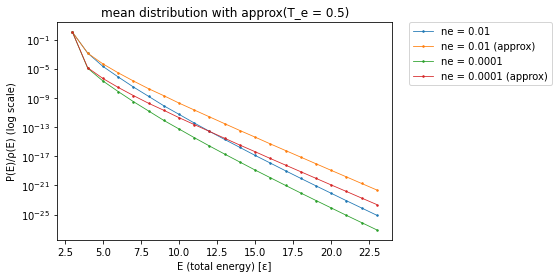

In [43]:
plots_mean_dist_for_approx([0.01, 0.0001])

## `coeff`を正規化するのではなく、単位行列を正規化してべき乗法で解く

In [174]:
fermi = Fermi(states3, equ=False, Te=0.5, ne=0.0001)
states = fermi.states

if np.all(fermi.excitation == 0):
    fermi._make_matrices()
C_ = np.diag(sum_along_axis(fermi.excitation, 1))
F_ = np.diag(sum_along_axis(fermi.deexcitation, 0))
C = fermi.excitation
F = fermi.deexcitation
coeff = C_ - F - C.T + F_
if not fermi.equ:
    A_ = np.diag(sum_along_axis(fermi.emission, 0))
    A = fermi.emission
    coeff += A_ - A

positive = -coeff + np.max(np.abs(np.diag(coeff))) * np.eye(C.shape[0])
normalized = -coeff / np.max(np.abs(np.diag(coeff))) + np.eye(C.shape[0])

In [177]:
eigen, x = power(positive)
x = x / np.sum(x)

In [178]:
print(eigen)

44100.00199910432


In [179]:
x

array([9.99986396e-01, 1.31689631e-05, 2.06017037e-07, 2.05745066e-07,
       6.92080161e-09, 8.58865928e-09, 6.90784779e-09, 3.36312011e-10,
       4.54410964e-10, 9.41938100e-14, 4.54093973e-10, 2.02061298e-11,
       2.80608350e-11, 5.07284094e-15, 3.17782337e-11, 5.07039769e-15,
       1.39444331e-12, 1.93968766e-12, 3.27272402e-16, 8.59803168e-17,
       2.35541750e-12, 3.49911175e-16, 8.58376863e-17, 1.06122766e-13,
       1.46205764e-13, 2.35586821e-17, 5.37439659e-18, 1.84029787e-13,
       2.65458624e-17, 5.72414427e-18, 5.71695864e-18, 8.68678717e-15,
       1.17996357e-14, 1.83595612e-18, 3.87248987e-19, 2.00498819e-19,
       1.50884643e-14, 2.12793473e-18, 4.12334956e-19, 4.29293202e-19,
       2.59709490e-19, 7.52328140e-16, 1.00614371e-15, 1.52156792e-19,
       3.04660867e-20, 1.40319058e-20, 1.29195876e-15, 1.78550599e-19,
       3.28720681e-20, 1.55832749e-20, 3.47085851e-20, 1.88681716e-20,
       2.62691276e-24, 6.81539547e-17, 8.97448956e-17, 1.32494730e-20,
      

In [180]:
eigen_usual, x_usual = power(normalized)
x_usual = x_usual / np.sum(x_usual)

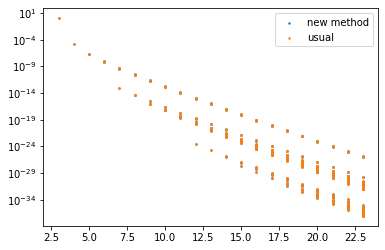

In [185]:
scores = [state.score for state in states]
plt.scatter(scores, x, label="new method", s=2)
plt.scatter(scores, x_usual, label="usual", s=2)
plt.legend()
plt.yscale("log")
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

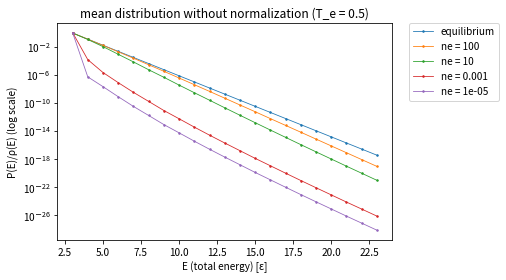

In [47]:
plots_mean_dist_without_normalization([100, 10, 0.001, 0.00001], include_equ=True)

  0%|          | 0/4 [00:00<?, ?it/s]

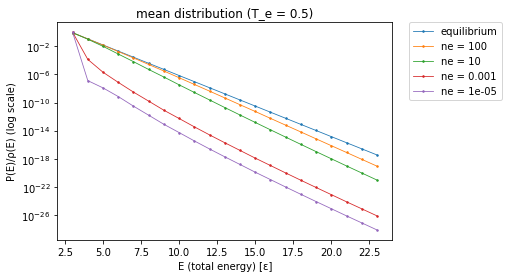

In [4]:
plots_mean_dist([100, 10, 0.001, 0.00001], include_equ=True)

  0%|          | 0/4 [00:00<?, ?it/s]

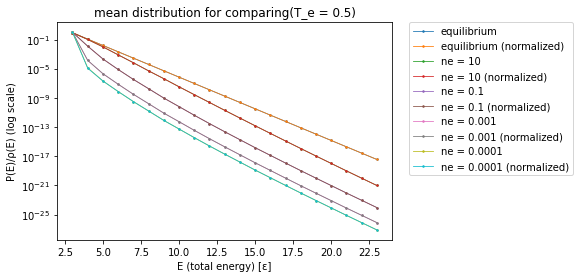

In [2]:
plots_mean_dist_compare([10, 0.1, 0.001, 0.0001], include_equ=True)